(sec:GPforML)=
# Gaussian Processes for Machine Learning

## Gaussian Processes 

A Gaussian proccess is a paricular type of stochastic process. *But what do we understand by a stochastic process?* Typically, a stochastic process denotes a collection of random variables with a time dependence. Hence, the term *stochastic* is justified by the consideration of *random variables* and *process* relates to the *time dependence*. 
We state the following brief definition:

```{admonition} Definition
:class: tip
:name: def:tsp
A **(temporal) stochastic process** is a collection of $\mathbb{R}^k$-valued random variables $(X_t)_{t \in \mathcal{I}}$, where either $\mathcal{I} = \mathbb{N}$ (discrete-time) or $\mathcal{I} = \mathbb{R}_{\ge 0}$ (continuous-time).
```

Hence, this kind of stochastic process describes the temporal process of random events. In this context, it makes sense to say that the outcome of $X_s$ happended before $X_t$ for $s < t$. Keep in mind that each random variable $X_t$ is a map $X_t: \Omega \rightarrow \mathbb{R}^d$ and $X_t(\omega)$ for $\omega \in \Omega$ is the outcome of a random experiment. The use of a stochastic process makes it possible to consider the outcomes of all random variables simultaneously. In this way, a so-called **sample path** or **random path** $(X_t(\omega))_{t \in \mathcal{I}}$ is obtained. The shape of these paths depend strongly on the underlying properties of the stochastic process.

A very famous example is **Brownian motion** or **Wiener process** which has numerous applications in physics, finance, biology and many other areas. For example, the movement of a large particle (like pollen) due to collisions with small particles (like water molecules). A nice simulation can be found on the website of Andrew Duffy at Boston University (please click on the image to follow the link):

<a href="http://physics.bu.edu/~duffy/HTML5/brownian_motion.html"> <center><img src="BManim.gif"></center></a>

Please note that the 2d simulation shows the current position of some particle as well as its previous path. In one dimension, we can easily simulate sample paths of Brownian motion starting at $X_0 =0$ and plot the result as position against time:

<img src="bm.gif" width="800px" alt="Brownian motion"/>

The concept can be generalized to general index sets and in particular, to $\mathbb{R}^d$. In the preceding animation time-dependent random functions are genarted, i.e., for each input $t$ is mapped to a random variable $f(t)$ ($X_t$ with the earlier notation). For our machine learning applications we are interested in general inputs $x \in \mathbb{R}^d$ with scalar random variables $f(x)$. In other words, a time-index is too restrictive and therefore, we generalize the idea to general index sets. Moreover, in view of the nice properties of normal distributions an additional property is supposed:

```{admonition} Definition
:class: tip
:name: def:gp
A Gaussian process is a collection of random variables, any finite number of which have a joint Gaussian distribution.{cite}```Rasmussen2006```
```

Henceforth, a Gaussian process is denoted by $(f(x))_{x \in \mathcal{I}}$. We assume that the random variables $f(x)$, $x \in \mathcal{I}$, take **scalar values** (i.e., values in $\mathbb{R}$). Moreover, $\mathcal{I} = \mathbb{R}^d$ for some $d \in \mathbb{N}$ unless stated otherwise. In this case, $(f(x))_{x \in \mathcal{I}}$ is also called a **random field** instead of random process. The additional Gaussian condition means that for an arbitrary number of elements $x_i \in \mathbb{R}^d$, $i=1, \dots, n$, the $\mathbb{R}^n$-valued random vector 

$$\begin{pmatrix} f(x_1) \\ f(x_2) \\ \vdots \\ f(x_n) \end{pmatrix}$$

is mulivariate normally distributed. By construction the Gaussian process yields random functions from $\mathbb{R}^d$ to $\mathbb{R}$. Moreover, Brownian motion is a specific Gaussian process.

In {ref}```def:multnormal```, we have seen that a multivariate normal distribution is uniquely characterized by its mean $\mu$ and covariance $\Sigma$. A Gaussian process is an infinite-dimensional analogue if the index set is infinite. Indeed, we can select an arbitrary number of $x_i$ values and consider the corresponding multivariate normal distribution of arbitrary dimension. It turns out that **a Gaussian process is also specified by its mean and covariance, but they are functions instead of a vector and a matrix**. More precisely, the **mean** is a function

$$m: \mathbb{R}^d \rightarrow \mathbb{R}, x \mapsto m(x)$$

and the **covariance function** or **kernel** is a function of two variables

$$k: \mathbb{R}^d \times \mathbb{R}^d \mapsto \mathbb{R}, (x, x^{\prime}) \mapsto k(x, x^{\prime})$$

Then, the finite-dimensional distributions of the Gaussian process are given by $m$ and $k$, i.e., the distribution of 

$$\begin{pmatrix} f(x_1) \\ f(x_2) \\ \vdots \\ f(x_n) \end{pmatrix} \sim \mathcal{N}(\mu, \Sigma)$$

is specified by

$$\mu = \begin{pmatrix} m(x_1) \\ m(x_2) \\ \vdots \\ m(x_n) \end{pmatrix}$$

and 

$$\Sigma = \begin{pmatrix} k(x_1, x_1) & k(x_1, x_2) & \dots & k(x_1, x_n) \\ 
k(x_2, x_1) & k(x_2, x_2) & \dots & k(x_2, x_n) \\ 
\vdots & \vdots & \ddots & \vdots \\ 
k(x_n, x_1) & k(x_n, x_2) & \dots & k(x_n, x_n) \end{pmatrix}$$

Thus, a Gaussian process is specified by choosing a mean function $m$ and a kernel $k$. We also write

$$ f \sim \mathcal{GP}(m, k).$$

If $m$ is zero, the corresponding Gaussian process is called **centered**.

The kernel $k$ generates the covariance matrix $\Sigma$ and the covariance of a multivariate normal distiribution possesses certain properties such as symmetry and positive definiteness. Consequently, a general function of two variables will not be a valid covariance function of a Gaussian process. Clearly, a covariance function is necessarily **symmetric**, i.e., $k(x, x^{\prime}) = k(x^{\prime}, x)$ for $x, x^{\prime} \in \mathcal{I}$. **Positive definiteness** of covariance function can also be defined, but requires some additional mathematical background (refer to (4.2) in {cite}```Rasmussen2006```).

A kernel $k$ is called **stationary** if it depends only on the difference of two inputs, i.e., $k(x, x^{\prime})$ depends only on $x - x^{\prime}$ for $x, x^{\prime} \in \mathbb{R}^d$. Furthermore, it is even **isotropic** if it depends only on the distance $r = |x - x^{\prime}|$.

The choice of $k$ determines the properties of the sample paths of the Gaussian process. For example, the paths can be very rough as for Brownian motion or they can be very smooth as for the squared exponential or RBF kernel:

<img src="smooth.gif" width="800px" alt="Gaussian process"/>

(sec:gpr)=
## Gaussian Process Regression

In the machine learning context, Gaussian processes are used for **Gaussian process regression** or **kriging**. We have some data set $\mathcal{D}$ of observations

$$\mathcal{D} = \{ (x_i, y_i)~|~x_i \in \mathbb{R}^d, y_i \in \mathbb{R} \quad \text{for } i=1,\dots,n \}$$

similarly to the example in {ref}```sec:linregr```, but now the **functional relation** between inputs $x_i$ and outputs $y_i$ is not necessarily linear. Indeed, by assumption the relation is given by

$$y_i = f(x_i) + \varepsilon_i,$$

where $f$ is some function which is identified with (a sample path of) a suitable Gaussian process $f$. Either $\varepsilon_i=0$ for $i=1,\dots,n$ if the data is noise-free or $\varepsilon_i$, $i=1,\dots,n$, are independent $\mathcal{N}(0, \sigma_n^2)$-distributed random variables if the data is noisy. Please note that the labels $y_i$ are assumed to be $\mathbb{R}$-valued. The case of multiple outputs is discussed later on in {ref}```sec:multiout```.

The basic idea is to consider only those sample paths of the Gaussian process which match the data. From the Bayesian point of view, the initial Gaussian process defines a **prior distribution over functions** and restriction to fitting sample paths yields the **posterior distribution over functions** given the data $\mathcal{D}$. The follwing animation visualizes samples paths from the posterior distribution in use of the squared exponential kernel and eight noise-free observations from the sine function:

<img src="gaussianregr.gif" width="800px" alt="Cond Gaussian process"/>

Typically, the **mean function is chosen to be zero**. Otherwise $m$ would already approximate the dependence of the output $y$ of the input $x$. Learning this relation is purpose of the regression model. However, if we still like to use a non-zero mean $m$, this can also be done by substracting $m(x_i)$ from $y_i$ and considering a centered model on the residuals. Thus, we always make the assumption $m=0$, i.e., **we only consider centered Gaussian processes**.

For a test point $x^*$ the **distribution of** $f(x^*)$ **given the data** $\mathcal{D}$ is the {ref}```conditional distribution<lem:condnormaldistr>``` which can be computed explicitly, since we are dealing with normal distributions. The prediction of the model at $x^*$ is given by the mean of the conditional distribution and the uncertainty is quantified by the variance which corresponds to the variability of the string in the preceding animation. As seen before, this uncertainty can also be expressed in terms of credible intervals:

<img src="gaussianregr.png" alt="Cond Gaussian process"/>

The following interactive plot shows how the distribution of one component of a two dimensional normally distributed random vector behaves if the other component is fixed. The main observation is that the fixed value has no impact on the other component if the correlation is zero. In this case, the two components are independent. Moreover, the impact increases as the absolute value of the correlation increases. This means for Gaussian process regression that the impact of training points $x$ on the prediction for test points $x^*$ depends on the variance $k(x, x^*)$. Please open the notebook in Google Colab to use the visualization.

In [1]:
from IPython.display import display, clear_output
!pip install ipympl
clear_output()

%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

import numpy as np
import matplotlib
from scipy.stats import norm, multivariate_normal
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from ipywidgets import interact, FloatSlider
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
sns.set_style('darkgrid')

# Plot bivariate distribution
def generate_surface(mean, covariance, d):
    """Helper function to generate density surface."""
    nb_of_x = 100 # grid size
    x1s = np.linspace(-5, 5, num=nb_of_x)
    x2s = np.linspace(-5, 5, num=nb_of_x)
    x1, x2 = np.meshgrid(x1s, x2s) # Generate grid
    tmp = np.stack((x1, x2), axis=-1)
    pdf = multivariate_normal.pdf(tmp, mean=mean[:, 0], cov = covariance)
    return x1, x2, pdf

@interact(x_condition=FloatSlider(value=1., min=-2, max=2, step=0.1, continuous_update=False), 
          y_condition=FloatSlider(value=-1., min=-2, max=2, step=0.1, continuous_update=False), 
          correlation=FloatSlider(value=0.99, min=-0.995, max=0.995, step=0.001, continuous_update=False))
def plot_conddistr(x_condition, y_condition, correlation):
    d = 2  # dimensions
    mean = np.array([[0.], [0.]])
    cov = np.matrix([
        [1, correlation], 
        [correlation, 1]
    ])

    # Get the mean values from the vector
    mean_x = mean[0,0]
    mean_y = mean[0,0]
    # Get the blocks (single values in this case) from 
    #  the covariance matrix
    A = cov[0, 0]
    B = cov[1, 1]
    C = cov[0, 1]  # = C transpose in this case
    # Calculate x|y
    mean_xgiveny = mean_x + C /B * (y_condition - mean_y)
    cov_xgiveny = A - C**2 /B

    # Calculate y|x
    mean_ygivenx = mean_y + C /A * (x_condition - mean_x)
    cov_ygivenx = B - C**2 /A
    # Plot the conditional distributions
    fig = plt.figure(figsize=(9, 9))
    gs = gridspec.GridSpec(
        2, 2, width_ratios=[1.5, 1], height_ratios=[1.5, 1],
        hspace=0.25)
    plt.suptitle('Conditional distributions', y=0.93)

    # Plot surface on top left
    ax1 = plt.subplot(gs[0])
    x, y, p = generate_surface(mean, cov, d)
    # Plot bivariate distribution
    con = ax1.contourf(x, y, p, 33, cmap='turbo')
    # y=1 that is conditioned upon
    ax1.plot([-3.5, 3.5], [y_condition, y_condition], 'r--')
    # x=-1. that is conditioned upon
    ax1.plot([x_condition, x_condition], [-3.5, 3.5], 'b--')
    ax1.set_xlabel('$x$', fontsize=13)
    ax1.set_ylabel('$y$', fontsize=13)
    ax1.yaxis.set_label_position('right')
    ax1.axis([-3.5, 3.5, -3.5, 3.5])

    # Plot y|x
    ax2 = plt.subplot(gs[1])
    yx = np.linspace(-5, 5, num=250)
    pyx = norm.pdf(yx, loc=mean_ygivenx, scale=np.sqrt(cov_ygivenx))
    # Plot univariate distribution
    ax2.plot(pyx, yx, 'b--', 
             label=f'$p(y|x={x_condition:.1f})$')
    ax2.legend(loc=0)
    ax2.set_xlabel('density', fontsize=13)
    ax2.set_xscale('symlog')
    ax2.set_xlim(0., 4.)
    ax2.set_xticks(ticks=[1., 2., 3., 4.])
    ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax2.set_ylim(-3.5, 3.5)
    title2 = r'$\mu_{y|x} =$' + '{:.2f}, '.format(mean_ygivenx)
    title2 += r'$\sigma_{y|x}^2 =$' + '{:.2f}'.format(cov_ygivenx)
    ax2.set_title(title2)

    # Plot x|y
    ax3 = plt.subplot(gs[2])
    xy = np.linspace(-5, 5, num=250)
    pxy = norm.pdf(xy, loc=mean_xgiveny, scale=np.sqrt(cov_xgiveny))
    # Plot univariate distribution
    ax3.plot(xy, pxy, 'r--', 
             label=f'$p(x|y={y_condition:.1f})$')
    ax3.legend(loc=0)
    ax3.set_ylabel('density', fontsize=13)
    ax3.yaxis.set_label_position('right')
    ax3.set_xlim(-3.5, 3.5)
    ax3.set_yscale('symlog')
    ax3.set_ylim(0., 4.)
    ax3.set_yticks(ticks=[1., 2., 3., 4.])
    ax3.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    title3 = r'$\mu_{x|y} =$' + '{:.2f}, '.format(mean_xgiveny)
    title3 += r'$\sigma_{x|y}^2 =$' + '{:.2f}'.format(cov_xgiveny)
    ax3.set_title(title3)

    # Clear axis 4 and plot colarbar in its place
    ax4 = plt.subplot(gs[3])
    ax4.set_visible(False)
    divider = make_axes_locatable(ax4)
    cax = divider.append_axes('left', size='20%', pad=0.05)
    cbar = fig.colorbar(con, cax=cax)
    cbar.ax.set_ylabel('density: $p(x, y)$', fontsize=13)
    plt.show()

interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='x_condition', max=2.0, min=…

The general equations for Gaussian process regression without noise are derived as follows:

Let 

$$X = \begin{pmatrix} x^T_1 \\ x^T_2 \\ \vdots \\ x^T_n \end{pmatrix}$$

be the so called **sample matrix** and denote by

$$y = \begin{pmatrix} y_1 \\ y_2 \\ \vdots \\ y_n \end{pmatrix}$$

the associated **labels**. $X$ and $y$ split the training data $\mathcal{D}$ into inputs and outputs. Assume that we have some test points

$$X^* = \begin{pmatrix} {x^*}^T_1 \\ {x^*}^T_2 \\ \vdots \\ {x^*}^T_m \end{pmatrix}$$

for some $m \in \mathbb{N}$. Our goal is to determine the distribution of 

$$f(X^*) := \begin{pmatrix} f(x^*_1) \\ f(x^*_2) \\ \vdots \\ f(x^*_m) \end{pmatrix}$$

given

$$\begin{pmatrix} f(x_1) \\ f(x_2) \\ \vdots \\ f(x_n) \end{pmatrix} = \begin{pmatrix} y_1 \\ y_2 \\ \vdots \\ y_n \end{pmatrix}$$

Since we use a Gaussian process with zero mean, we know that 

$$\begin{pmatrix} f(x^*_1) \\ f(x^*_2) \\ \vdots \\ f(x^*_m) \\ f(x_1) \\ f(x_2) \\ \vdots \\ f(x_n) \end{pmatrix} \sim \mathcal{N}(0, \Sigma)$$

The kernel $k$ determines the covariance matrix $\Sigma$. We use the notation

$$K(X, X^*) = \begin{pmatrix} k(x_1, x^*_1) & k(x_1, x^*_2) & \dots & k(x_1, x^*_m) \\ 
k(x_2, x^*_1) & k(x_2, x^*_2) & \dots & k(x_2, x^*_m) \\ 
\vdots & \vdots & \ddots & \vdots \\ 
k(x_n, x^*_1) & k(x_n, x^*_2) & \dots & k(x_n, x^*_m) \end{pmatrix}$$

$K(X, X)$, $K(X^*, X^*)$ and $K(X^*, X)$ are defined accordingly. Consequently, it follows

$$\Sigma = \begin{pmatrix} K(X^*, X^*) & K(X^*, X) \\ K(X, X^*) & K(X, X) \end{pmatrix}$$

Finally, we can apply {ref}```conditional distribution formula<lem:condnormaldistr>``` to deduce the following:

```{admonition} Lemma
:class: important
:name: lem:gpregr
Gaussian process regression predicts the distribution of $f(X^*)$ given the data $\mathcal{D}$ by a multivariate normally distributed with mean

$$\mathbb{E}(f(X^*)) = K(X^*, X) K(X, X)^{-1} y$$

and covariance

$$\text{cov}(f(X^*)) = K(X^*, X^*) - K(X^*, X) K(X, X)^{-1} K(X, X^*)$$
```

By definition of the conditional probability distribution, the following density has the stated distribution

$$
p(y^*~|~X^*, X, y) = \frac{p(y, y^*~|~X^*, X)}{p(y~|~X^*, X)} = \frac{p(y, y^*~|~X^*, X)}{p(y~|~X)},
$$ (level1)

where $p(y^*~|~X^*, X, y)$ denotes the likelihood that $f(X^*)$ attains the value $y^*$ given $X$ and $y$. The marginal likelihood $p(y~|~X)$, i.e., the likelihood of $f(X) = y$ will be of particular importance in {ref}```sec:selectofhyperp```.

The term $\alpha := K(X, X)^{-1} y$ is a vector of size $n$ which is independent of $x^*$. Moreover, for a single test point $x^*$ the covariance matrix $K(x^*, X)$ reduces to a row vector. Hence, it holds

$$\mathbb{E}(f(x^*)) = K(x^*, X) \alpha = \sum_{i=1}^n \alpha_i~ k(x^*, x_i).$$

In other words, the **mean prediction is a linear combination of the functions** $k(\cdot, x_i)$, $i=1, \dots, n$. The weights $\alpha_i$, $i=1,\dots,n$, are constructed such that the training data is fitted exactly (see plot above). This is **only possible if the inverse matrix** $K(X, X)^{-1}$ **exists**. This might not always the case. Think of the linear regression example including noise in the data. In this case, it is not possible to find a linear function which fits the data exactly. Furthermore, we possibly do not like to obtain a perfect fit, since we suppose that our training data contains noise. In order to solve this issue, a **noise term** $\sigma_{\text{noise}}^2 > 0$ is added to the covariance related to the training data, i.e., $K(X, X)$ is replaced by $K(X, X) + \sigma_{\text{noise}}^2 I_n$, where $I_n$ denotes the identity matrix. In this way, the variance of $f(x_i)$, $i=1,\dots,n$, is increased by $\sigma_{\text{noise}}^2$. Adding noise is additionally useful to **avoid numerical problems**, since it has a regularizing effect. Indeed, the inverse matrix $K(X, X)^{-1}$ might exist mathematically. However, if the matrix is "almost singular", it is often not possible to compute $K(X, X)^{-1}$. It holds

```{admonition} Lemma
:class: important
:name: lem:gpregrnoise
Gaussian process regression with noise $\sigma_{\text{noise}}^2$ predicts the distribution of $f(X^*)$ given the data $\mathcal{D}$ by a multivariate normally distributed with mean

$$\mathbb{E}(f(X^*)) = K(X^*, X) \big(K(X, X) + \sigma_{\text{noise}}^2 I_n\big)^{-1} y$$

and covariance

$$\text{Cov}(f(X^*)) = K(X^*, X^*) - K(X^*, X) \big(K(X, X) + \sigma_{\text{noise}}^2 I_n\big)^{-1} K(X, X^*)$$
```

It is also possible to incorporate the {ref}```result with noise<lem:gpregrnoise>``` informally into the {ref}```case without noise<lem:gpregr>``` by replacing the kernel $k$ by $k + \sigma_{\text{noise}}^2 \delta$ **only for samples from $X$**, where

$$ \delta(x, x') = \begin{cases} 1, & \text{if } x = x^{\prime} \\
                                 0, & \text{if } x \ne x^{\prime}
                   \end{cases}
$$

In this way, the noise $\sigma_{\text{noise}}^2$ is added to the diagonal of $K(X, X)$ and the notation is maintained. However, this modification must not be used for test points $X^*$, since the noise should not appear in $K(X^*, X)$ or $K(X^*, X^*)$.

## Examples of Kernels 

As mentioned before, the choice of the kernel (the prior distribution) determines the properties of the Gaussian process and consequently also of the regression model. In the present section, we define the most common covariance functions and visualize the corresponding sample paths.

<IPython.core.display.Javascript object>


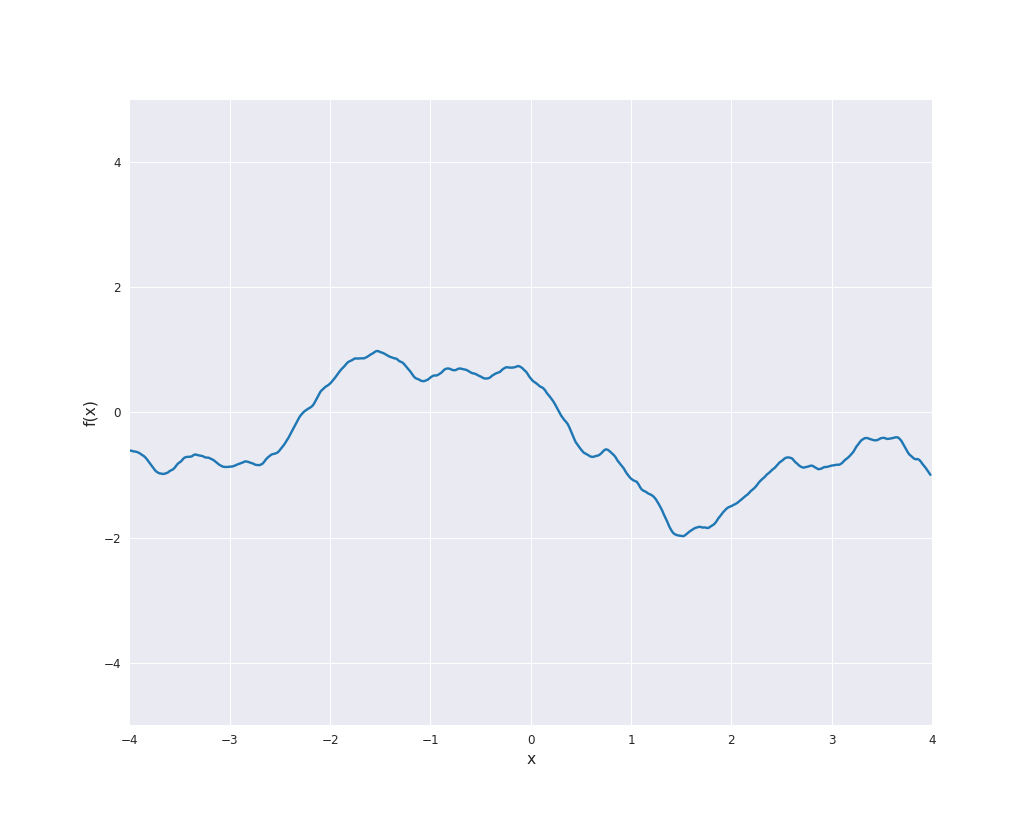

In [2]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegFileWriter
import seaborn as sns
sns.set_style('darkgrid')

# animation for paths of a Gaussian process
# kernel specifies the covariance function
# x-values from -xbnd to xbnd
# y-axis has values from -ybnd to ybnd
# saves gif if string is passed to name
def get_anim(kernel, xbnd=10., ybnd=2.5, name=None):
    nb_steps = 500
    delta_x = 2*xbnd / nb_steps
    x = np.arange(-xbnd, xbnd, delta_x)
    mean = np.zeros_like(x)
    cov = kernel(x.reshape(-1, 1))

    # First set up the figure, the axis, and the plot element we want to animate
    fig = plt.figure(num=' ', figsize=(10, 8))
    ax = plt.axes(xlim=(-xbnd, xbnd), ylim=(-ybnd, ybnd))
    ax.set_xlabel('x', fontsize=13)
    ax.set_ylabel('f(x)', fontsize=13)
    line, = ax.plot([], [], lw=2)

    # initialization function: plot the background of each frame
    def init():
        line.set_data([], [])
        return line,

    # animation function.  This is called sequentially
    def animate(i):
        x = np.arange(-xbnd, xbnd, delta_x)
        samples = np.random.multivariate_normal(mean, cov)
        line.set_data(x, samples)
        return line,

    # call the animator.  blit=True means only re-draw the parts that have changed.
    anim = FuncAnimation(fig, animate, init_func=init,
                         frames=50, interval=400, blit=True) #, repeat=False)
    if name is not None:
        anim.save(name + '.gif', writer=FFMpegFileWriter(fps=2)) #, dpi=200)
    return anim

# common kernels:
from sklearn.gaussian_process.kernels import DotProduct # linear kernel
from sklearn.metrics.pairwise import polynomial_kernel # polynomial kernel
from sklearn.gaussian_process.kernels import RBF # squared exponential kernel
from sklearn.gaussian_process.kernels import Matern # Matern kernel
from sklearn.gaussian_process.kernels import RationalQuadratic # rational quadratic kernel
from sklearn.gaussian_process.kernels import ExpSineSquared # periodic kernel

# example
kernel = Matern(nu=1.5) 
anim = get_anim(kernel, xbnd=4., ybnd=5.)

### Linear Kernel

The linear kernel reads

$$k(x, x^{\prime}) = \beta_0 + \langle x, x^{\prime} \rangle \quad \text{for } x, x^{\prime} \in \mathbb{R}^d,$$

where $\beta_0 \ge 0$ and $\langle x, x^{\prime} \rangle$ denotes the scalar product of $x$ and $x^{\prime}$. In the subsequent animation, we used $\beta_0 = 0$.

<img src="linear.gif" width="800px" alt="Linear kernel"/>

### Polynomial Kernel

The polynomial kernel is constructed by exponentiation of the linear kernel, i.e.,

$$k(x, x^{\prime}) = \big(\beta_0 + \langle x, x^{\prime} \rangle\big)^p \quad \text{for } x, x^{\prime} \in \mathbb{R}^d,$$

where $\beta_0 \ge 0$ and $p \in \mathbb{N}$. In the subsequent animation, we used $\beta_0 = 1$ and $p=3$.

<img src="polynomial.gif" width="800px" alt="Polynomial kernel"/>

### Squared Exponential Kernel

The squared exponential kernel is possibly the most important kernel in kernel-based machine learning. It is also called radial basis function (RBF) kernel. It is defined by 

$$k(x, x^{\prime}) = \exp \big(-\frac{r^2}{2~l^2} \big)$$

where $r = |x - x^{\prime}|$ for $x, x^{\prime} \in \mathbb{R}^d$. $l$ is called **length scale** and is assumed to be positive. In particular, the squared exponential kernel is isotropic. In the subsequent animation, we used $l=1$.

<img src="rbf.gif" width="800px" alt="RBF kernel"/>

### Exponential Kernel

The (absolute) exponential kernel is another isotropic kernel and is defined by 

$$k(x, x^{\prime}) = \exp \big(-\frac{r}{l} \big)$$

where $r = |x - x^{\prime}|$ for $x, x^{\prime} \in \mathbb{R}^d$ and $l$ is the length scale. In the subsequent animation, we used $l=1$.

<img src="exp.gif" width="800px" alt="Exp kernel"/>

### Mat&eacute;rn Kernel

The Mat&eacute;rn kernel denotes a class of isotropic kernels which is parametrized by a parameter $\nu > 0$. The kernel is given by

$$k_{\nu}(x, x^{\prime}) = \frac{2^{1 - \nu}}{\Gamma(\nu)}~\Big(\frac{\sqrt{2\nu}~ r}{l}\Big)^{\nu} ~K_{\nu} \Big(\frac{\sqrt{2\nu}~r}{l}\Big),$$

where $r = |x - x^{\prime}|$ for $x, x^{\prime} \in \mathbb{R}^d$, $l >0$ is the length scale, $\Gamma$ is the gamma function and $K_{\nu}$ is a modified Bessel function.

For $\nu = 0.5$ the Mat&eacute;rn kernel becomes the exponential kernel and for $\nu \rightarrow \infty$ the Mat&eacute;rn kernel approaches the squared exponential kernel. Thus, $\nu$ determines the roughness of the samples paths and the samples paths get smoother as $\nu$ increases.

The most interesting other cases for machine learning are $\nu = 1.5$ and $\nu = 2.5$. It holds

$$k_{\nu = 1.5}(x, x^{\prime}) = \Big( 1 + \frac{\sqrt{3}~r}{l} \Big)~\exp\Big(\frac{\sqrt{3}~r}{l}\Big)$$

and 

$$k_{\nu = 2.5}(x, x^{\prime}) = \Big( 1 + \frac{\sqrt{5}~r}{l} + \frac{5~r^2}{3~l^2} \Big)~\exp\Big(\frac{\sqrt{5}~r}{l}\Big).$$

For both cases, sample paths are animated below with $l=1$.

$\nu = 1.5$:

<img src="matern15.gif" width="800px" alt="Matern 1.5 kernel"/>

$\nu = 2.5$:

<img src="matern25.gif" width="800px" alt="Matern 2.5 kernel"/>

### Rational Quadratic Kernel

The rational quadratic kernel denotes a family of isotropic kernels with parameter $\alpha > 0$ defined by

$$k_{\alpha}(x, x^{\prime}) = \Big( 1 + \frac{r^2}{2\alpha~l^2} \Big)^{-\alpha}$$

with $r = |x - x^{\prime}|$ for $x, x^{\prime} \in \mathbb{R}^d$ and $l > 0$. This kernel can be seen as mixture of squared exponential kernels with different length scales (see (4.20) in {cite}```Rasmussen2006```). In the subsequent animation, we used $\alpha = l = 1$.

<img src="rq.gif" width="800px" alt="rq kernel"/>

### Periodic Kernel

The periodic kernel is also called Exp-Sine-Squared kernel. It is given by

$$k(x, x^{\prime}) = \exp\Big( - \frac{2~\sin^2\big(\pi \frac{r}{p}\big)}{l^2}\Big)$$

with $r = |x - x^{\prime}|$ for $x, x^{\prime} \in \mathbb{R}^d$. $l$ is the length scale and $p$ the **periodicity**. To illustrate the sample paths we used $l=p=1$.

<img src="periodic.gif" width="800px" alt="Periodic kernel"/>

### Brownian Motion Kernel

Since we illustrated the sample paths of Brownian motion as an example for a stochastic process, we state its covariance function. Nevertheless, this kernel is not of interest for our machine learning applications. It holds

$$k(s, t) = \text{min}(s, t)$$

for $s, t \in \mathbb{R}_{> 0}$.

(sec:combofkernels)=
## Combination of Kernels

It is possible to obtain new covariance functions from known kernels by recombination.

Let $(f_1(x))_{x \in \mathbb{R}^d}$ and $(f_2(x))_{x \in \mathbb{R}^d}$ be two independent centered Gaussian processes with kernels $k_1$ and $k_2$, respectively. Moreover, let $a : \mathbb{R}^d \rightarrow \mathbb{R}_{> 0}$. Then, sums and products can be used to generate new kernels $k$ and Gaussian processes $f$ from old ones:

| Gaussian process | kernel $k(x, x^{\prime})$ |
|:--------------------------|----------:|
| $f_1 + f_2$ | $k_1(x, x^{\prime})+k_2(x, x^{\prime})$ |
| $f_1 f_2$ | $k_1(x, x^{\prime}) k_2(x, x^{\prime})$ |
| $a f_1$ | $a(x) k_1(x, x^{\prime}) a(x^{\prime})$ |

Of course, a constant $a$ can be used for scaling and the three approaches can be combined arbitrarily.

For example, by multiplication of the periodic kernel with the squared exponential kernel the **locally periodic kernel** is constructed:

$$k(x, x^{\prime}) = \exp\Big( - \frac{2~\sin^2\big(\pi \frac{r}{p}\big)}{l^2}\Big) \exp \Big(-\frac{r^2}{2~l^2} \Big),$$

where $r = |x - x^{\prime}|$ for $x, x^{\prime} \in \mathbb{R}^d$.

The sample paths are indeed locally periodic, i.e., the periodic part changes over time: 

In [3]:
kernel1 = ExpSineSquared()
kernel2 = RBF()

def kernel(x):
    return np.multiply(kernel1(x), kernel2(x))

# anim = get_anim(kernel, xbnd=4., ybnd=5.)

<img src="locperiodic.gif" width="800px" alt="locally periodic kernel"/>

Furthermore, **scaling of a Gaussian process** with kernel $k$ by a constant $\sigma \ne 0$ (i.e., choosing $a(x) = \sigma$ in the notation above) yields the kernel $\sigma^2 k$. This is also a common approach to modify kernel functions.

For additional techniques for creating new covariance functions please refer to section 4.2.4 in {cite}```Rasmussen2006```.

(sec:impactofhyperp)=
## Impact of Hyperparameters

Most kernels depend on so-called hyperparameters. For example, the length scale $l$ which appears in many of the previously stated examples, the noise variance $\sigma_{\text{noise}}^2$ as well as the scaling parameter $\sigma^2$ mentioned in {ref}```sec:combofkernels``` are hyperparameters. In addition to the genereal choice of the kernel, the exact values of these parameters determine the properties of the underlying Gaussian process. In general, we denote the collection of all hyperparameters of some kernel $k$ by $\theta$. Please note that $\theta$ is possibly vector valued, if $k$ possesses more than one hyperparameter.

For example, the scaled squared exponential kernel with positive hyperparameters $l$ and $\sigma^2$ is given by

$$k(x, x^{\prime}) = \sigma^2~\exp \big(-\frac{r^2}{2~l^2} \big)$$

where $r = |x - x^{\prime}|$ for $x, x^{\prime} \in \mathbb{R}^d$. Moreover, noise is variance $\sigma_{\text{noise}}^2$ is added. Thus, this kernel yields $\theta = (l, \sigma^2, \sigma_{\text{noise}}^2)$. A larger length scale implies a higher correlation between $f(x)$ and $f(x^{\prime})$. Similarly, higher value of $\sigma^2$ implies a smaller correlation.

Given a test point $x^*$, the {ref}```mean prediction and variance<lem:gpregr>``` in Gaussian process regression depend on $K(X, X)$ as well as $K(x^*, X)$ which in turn depend on $\theta$. Consequently, the hyperparmeters impact the model predictions.

For the case of the scaled squared exponential kernel with optional noise, the impact is shown in the following visualization which can be used in Google Colab:

In [3]:
# Gaussian process posterior
def cond_distr(X1, y1, X2, kernel):
    """
    Calculate the posterior mean and covariance matrix for y2
    based on the corresponding input X2, the observations (y1, X1), 
    and the prior kernel function.
    """
    # Kernel of the observations
    Σ11 = kernel(X1)
    # Kernel of observations vs to-predict
    Σ12 = kernel(X1, X2)
    # Solve
    solved = scipy.linalg.solve(Σ11, Σ12, assume_a='pos').T
    # Compute posterior mean
    μ2 = solved @ y1
    # Compute the posterior covariance
    Σ22 = kernel(X2, X2)
    Σ2 = Σ22 - (solved @ Σ12)
    return μ2[:, 0], Σ2  # mean, covariance

def _plot(mean, cov):
    fig= plt.figure(figsize=(14, 10))
    ax = plt.axes(xlim=(0, 10), ylim=(-2.5, 2.5))
    ax.scatter(X, Y)
    plt.plot(t, np.sin(t), label='true function')
    plt.plot(t, mean, c='purple', label='mean prediction')
    plt.fill_between(t, mean - 1.96 * np.sqrt(np.diag(cov)), mean + 1.96 * np.sqrt(np.diag(cov)), 
                     color='purple', alpha=.25, label='credible interval')
    plt.legend()
    plt.show()

In [8]:
from IPython.display import display, clear_output
!pip install ipympl
clear_output()

%matplotlib inline
from ipywidgets import interact, interact_manual, FloatSlider
import numpy as np
import scipy
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegFileWriter
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import ConstantKernel
from sklearn.gaussian_process.kernels import WhiteKernel

# sample training data
X = np.array([1.01, 3.51, 4.51, 7.01, 7.91, 9.01]).reshape(-1, 1)
Y = np.sin(X)
nb_steps = 500
delta_t = 10 / nb_steps
t = np.arange(0, 10, delta_t)

@interact(l=FloatSlider(value=2.05, min=1e-5, max=3, step=0.05, continuous_update=False), 
          sigma2=FloatSlider(value=1., min=1e-5, max=10, step=0.1, continuous_update=False),
          noise_level=FloatSlider(value=0., min=0., max=1., step=0.01, continuous_update=False))
def anim_hyper(l, sigma2, noise_level):
    kernel = ConstantKernel(constant_value=sigma2) * RBF(length_scale=l) + WhiteKernel(noise_level=noise_level)
    mean, cov = cond_distr(X, Y, t.reshape(-1, 1), kernel) 
    _plot(mean, cov)

interactive(children=(FloatSlider(value=2.05, continuous_update=False, description='l', max=3.0, min=1e-05, st…

(sec:selectofhyperp)=
## Selection of Hyperparameters

In {ref}```<sec:impactofhyperp>```, we have seen that the choice of the hyperparameters $\theta$ impacts the behavior of the Gaussian process regression model. Therefore, the question arises how the hyperparameters should be selected appropriately. In this context, the term "model fitting" is also used. Nevertheless, this approach is fundamentally different from fitting e.g. in case of linear/polynomial regression models or neural networks. These models try to minimize some loss function which calculates the error between the actual labels of the training data and the model predictions. In contrast, the Gaussian process regression model (without noise) has no such prediction error, since it is conditioned to fit the training samples. The selection of hyperparameters determines only how the regression model passes the training samples (refer to the previous animation).

In {eq}`level1` we have seen how the distribution of $f(X^*)$ is computed given $X$ and $y$. This procedure is also called level 1 inference. By incorporating the dependence of the distribution on $\theta$ the equation has the form

$$
p(y^*~|~X^*, X, y, \theta) = \frac{p(y, y^*~|~X^*, X, \theta)}{p(y~|~X, \theta)},
$$ (level1b)

From the Bayesian point of view, a natural approach would be to choose a prior distribution on the hyperparameters $\theta$ and to compute the posterior distribution of $\theta$ in use of Bayesian inference:

$$
\begin{align}
p(\theta~|~X, y) &= \frac{p(y~|~X, \theta)~p(\theta~|~X)}{p(y~|~X)} \\
&= \frac{p(y~|~X, \theta)~p(\theta)}{\int p(y~|~X, \theta)~p(\theta) ~d\theta}
\end{align}$$ (level2)

Please note that the marginal likelihood $p(y~|~X, \theta)$ from {eq}`level1b` plays the role of the likelihood in the level 2 inference in {eq}`level2`.

Then, the posterior predictive distribution reads

$$p(y^*~|~X^*, X, y) = \int p(y^*~|~X^*, X, y, \theta) ~ p(\theta~|~X, y)~d\theta.$$

In particular, the expected values of $y*$ is given by

$$
\begin{align}
\mathbb{E}(y^*) &= \int y^* \int p(y^*~|~X^*, X, y, \theta) ~ p(\theta~|~X, y)~d\theta ~dy^* \\
&= \int \int y^* p(y^*~|~X^*, X, y, \theta) ~dy^*~ p(\theta~|~X, y)~d\theta \\
&= \int K_{\theta}(X^*, X) K_{\theta}(X, X)^{-1} y ~ p(\theta~|~X, y)~d\theta,
\end{align}
$$

where $K_{\theta}$ illustrates the dependence of the kernel $k$ and hence, of $K$ on $\theta$.

However, the marginal likelihood $p(y~|~X) = \int p(y~|~X, \theta)~p(\theta) ~d\theta$ usually requires approximations, since it can not be computed analytically. This can for example be done in use of [MCMC methods](https://gpflow.readthedocs.io/en/master/notebooks/advanced/mcmc.html).

In most cases, the **MLE or sometimes a MAP estimate for $\theta$ is used** to obtain a predictive Gaussian process model. More precisely, a prior distribution for $\theta$ is chosen and the estimate is given by

$$\begin{align}
  \hat{\theta} &= \underset{\theta}{\text{argmax}}~ p(y~|~X, \theta)~p(\theta) \\
               &= \underset{\theta}{\text{argmax}}~ \ln \big(p(y~|~X, \theta)\big) + \ln \big(p(\theta)\big) \\
               &= \underset{\theta}{\text{argmax}}~ \ln \big(p(y~|~X, \theta)\big) + \ln \big(p(\theta)\big) \\
               &= \underset{\theta}{\text{argmax}}~ \mathcal{L}(\theta~|~X, y) + \ln \big(p(\theta)\big),
  \end{align}$$
               
where 

$$\begin{align}
\mathcal{L}(\theta~|~X, y) &= \ln \Big( \frac{1}{\sqrt{(2\pi)^d |K_{\theta}(X, X)|}} ~\exp\Big(-\frac{1}{2}~y^T K_{\theta}(X, X)^{-1}y\Big)\Big)\\
&= - \frac{d}{2} \ln \big(2 \pi \big) - \ln \big(|K_{\theta}(X, X)| \big) - \frac{1}{2} y^T K_{\theta}(X, X)^{-1}y
\end{align}$$

denotes the so-called **log marginal likelihood**. MLE implies that $p(\theta)$ is independent of $\theta$ and therefore, the MLE estimate is given by

$$\hat{\theta} = \underset{\theta}{\text{argmax}}~ \mathcal{L}(\theta~|~X, y)$$

The term $- \frac{1}{2} y^T K_{\theta}(X, X)^{-1}y$ is called **data-fit** and $\ln \big(|K_{\theta}(X, X)| \big)$ is the **complexity penalty**. The counterplay of these two terms provides an automatic trade-off which tends to the **least complex model which is able to explain the given data**. This principle is also known as [Occam's razor](https://en.wikipedia.org/wiki/Occam%27s_razor).
               
MLE implies that $p(\theta)$ is independent of $\theta$ and therefore, the MLE estimate is given by

$$\hat{\theta} = \underset{\theta}{\text{argmax}}~ \mathcal{L}(\theta~|~X, y)$$

The log marginal likelihood for the example illustrated in {ref}```sec:impactofhyperp``` in dependence of the length scale $l$ with fixed values $\sigma_{\text{noise}}^2 = 0$ and $\sigma^2 = 1$ is given as follows:

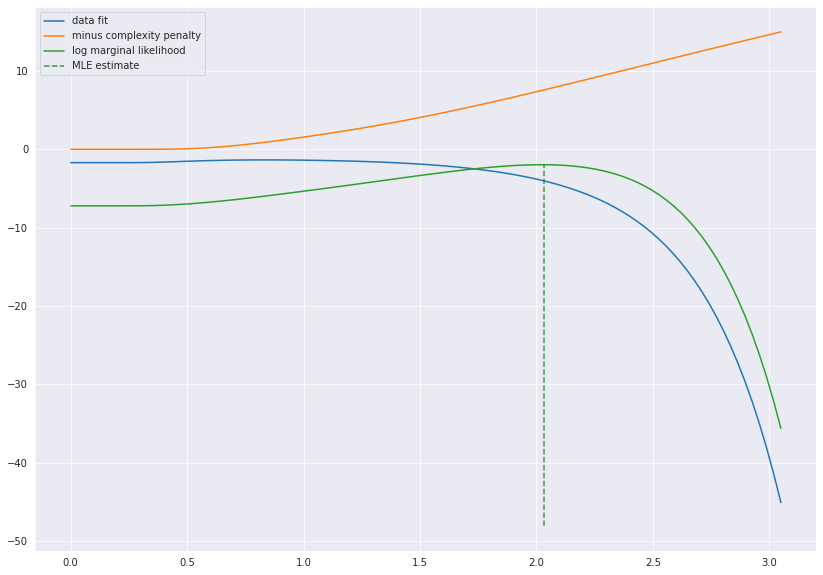

The MLE estimate for l is 2.03


In [9]:
def log_marginal_likelihood(l):
    kernel = ConstantKernel(constant_value=1.) * RBF(length_scale=l) + WhiteKernel(noise_level=0.)
    K = kernel(X, X)
    datafit = - np.matmul(Y.reshape(1, -1), np.linalg.solve(K, Y.reshape(-1, 1)))/2
    complexity = - np.log(np.linalg.det(K))
    lml = - X.shape[0]/2 * np.log(2*np.pi) + datafit + complexity
    return datafit[0], complexity, lml[0]
                        
length_scales = np.linspace(1e-5, 3.05, num=100)
datafits, complexities, lmls = [], [], []
for l in length_scales:
    datafit, complexity, lml = log_marginal_likelihood(l)
    datafits.append(datafit)
    complexities.append(complexity)
    lmls.append(lml)
                          
fig= plt.figure(figsize=(14, 10))
plt.plot(length_scales, datafits, label='data fit')
plt.plot(length_scales, complexities, label='minus complexity penalty')
plt.plot(length_scales, lmls, label='log marginal likelihood')
plt.vlines(length_scales[np.argmax(lmls)], plt.ylim()[0], np.max(lmls), colors='green', alpha=0.75, 
           linestyles='dashed', label='MLE estimate')
plt.legend()
plt.show()
print('The MLE estimate for l is {:.2f}'.format(length_scales[np.argmax(lmls)]))                        

(sec:multiout)=
## Extension to Multiple Outputs

In {ref}```sec:gpr```, we considered the single output case and the data $\mathcal{D}$ of observations was of the form

$$\mathcal{D} = \{ (x_i, y_i)~|~x_i \in \mathbb{R}^d, y_i \in \mathbb{R} \quad \text{for } i=1,\dots,n \}$$

In the present section, we consider the multi-output case, i.e., $\mathcal{D}$ is given by

$$\mathcal{D} = \{ (x_i, y_i)~|~x_i \in \mathbb{R}^d, y_i \in \mathbb{R}^k \quad \text{for } i=1,\dots,n \}$$

with some $k \ge 2$ and the functional relation between inputs $x_i$ and outputs $y_i$ reads

$$y_i = f(x_i) + \varepsilon_i,$$

where $f: \mathbb{R}^d \rightarrow \mathbb{R}^k$ which is identified with (a sample path of) a suitable Gaussian process $f$ and $\varepsilon_i$, $i=1,\dots,n$, are $\mathbb{R}^k$-valued centered independent multivariate Gaussian random variables.

In order to construct a Gaussian process regression model, some simple strategies exist:

- Under the assumption that the components of the output are independent, a single output model as stated in {ref}```sec:gpr```can be fitted 
    - separately for each component or
    - jointly by maximizing the sum of log marginal likelihoods (shared hyperparameters)
- Otherwise, i.e., if the compontents of the output are correlated, a possibility is to assume that there exists some function $g: \mathbb{R}^d \rightarrow \mathbb{R}^m$ and a matrix $W \in \mathbb{R}^{k \times m}$ such that 

 $$f(x) = Wg(x)$$
 
 and the compontents of $g$ are independent. This means that $f$ is at least the linear transformation of independent compontents. Then, a Gaussian process regression model can be fitted for $g$ and the transformation $W$ can be applied additionally. A popular method to construct $W$ is the use of [principal component analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) of the labels $y$ (also called singular value decomposition (SVD) or proper orthogonal decomposition (POD)). The idea can also be generalized to non-linear transformation such as [autoencoders](https://en.wikipedia.org/wiki/Autoencoder).
 
References to further approaches can be found in Section 9.1 of {cite}```Rasmussen2006```.

## Gaussian Process Classification

Gaussian process are not only used for regression, but also for classification problems. Gaussian process classification uses a latent regression model to predict class probabilities. In a first step, we discuss binary classification and afterwards the setting is generalized to multiclass classification.

(sec:binaryclass)=
### Binary Classification

In binary classification the data $\mathcal{D}$ is of the form

$$\mathcal{D} = \{ (x_i, y_i)~|~x_i \in \mathbb{R}^d, y_i \in \{-1, 1\} \quad \text{for } i=1,\dots,n \},$$

i.e., the (discrete) label has either value $-1$ or $1$ representing the two possible classes. The sample matrix $X$ and the lables $y$ are constructed as before.

For a test point $x^*$, the aim is to predict the **class probabilities** of the output $y^*$, i.e., the probabilities $p(y^*=1~|~X, y, x^*)$ and $p(y^*=-1~|~X, y, x^*)$. In this way, we obtain one discrete probability distribution on $\{-1, 1\}$ for each $x^*$. Since 

$$p(y^*=-1~|~X, y, x^*) = 1 - p(y^*=1~|~X, y, x^*),$$

it is sufficient to focus on $p(y^*=1~|~X, y, x^*)$. In other words, we are looking for a model which returns for a given input $x^*$ the probability that the corresponding label is $1$. For example, $x^*$ could be an image which shows either a cat or a dog. The model has to quantify the probability for dog and the complementary probability yields the probability for cat. Certainly, we desire values close to 0 or 1, since values near 0.5 imply that the model has difficulties to classify the input.

It holds $\sigma(z) \in [0,1]$, where 

$$\sigma(z) := \frac{1}{1 + \exp(-z)} \quad \text{for } z \in \mathbb{R}$$(deflogfct)

is the **logistic response function**. 

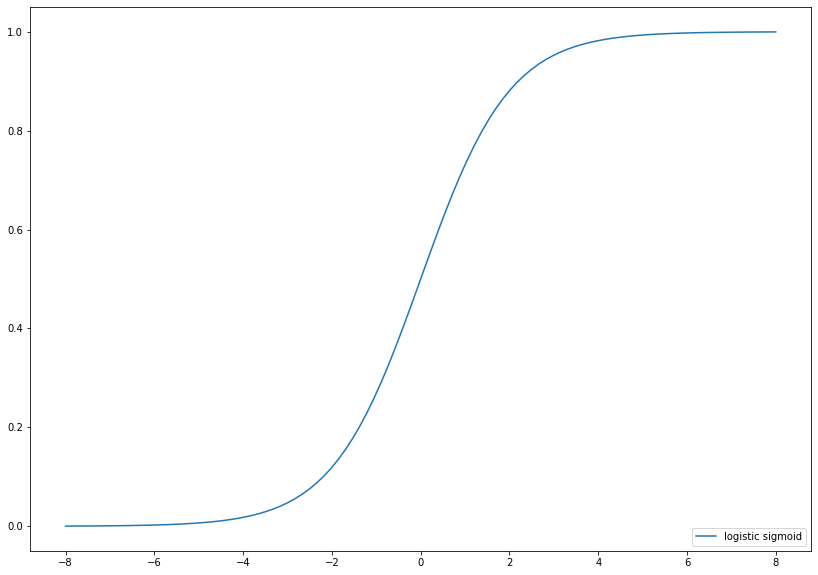

In [8]:
%matplotlib inline
import numpy as np
from scipy.special import expit
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

fig = plt.figure(figsize=(14, 10))
x = np.linspace(-8, 8, num=100)
plt.plot(x, expit(x), label='logistic sigmoid')
leg = plt.legend(loc='lower right')

Hence, the value of $\sigma(z)$ can be interpreted as a probability. It is also possible to use other response functions such as the Gaussian cdf, but we will restrict to $\sigma$.

Our aim is to construct the **distribution of a latent variable** $f^*$ given the data $\mathcal{D}$ and a test point $x^*$ (denote the pdf by $p(f^*~|~X, y, x^*)$) such that the class probability can be computed by the expectation of $p(y^*=1~|~f^*) := \sigma(f^*)$:

$$
p(y^*=1~|~X, y, x^*) &= \int_{\mathbb{R}} ~ p(y^*=1~|~f^*)~p(f^*~|~X, y, x^*)~df^* \\
&= \int_{\mathbb{R}} ~ \sigma(f^*)~p(f^*~|~X, y, x^*)~df^*.
$$ (classprob)

Please note that $p(y^*=-1~|~f^*) = 1 - p(y^*=1~|~f^*) = 1 - \sigma(f^*) = \sigma(-f^*)$ due to the properties of the logistic response function. Thus, the notation $p(y^*~|~f^*) = \sigma(y^* f^*)$ is also used. Moreover, we like to mention that $f^* < 0$ suggests that $y^* = -1$ is more likely and vice versa $f^* > 0$ implies that $y^* = 1$ is more likely.

*How can we construct $p(f^*~|~X, y, x^*)$ in* {eq}`classprob` *by means of Gaussian process regression*? 

The answer to this question is rather complicated and technical. For the interested reader, we give the details in the subsequent part:

````{admonition} Explanation.
:class: dropdown
We follow the explanation in sections 3.3 and 3.4 of {cite}```Rasmussen2006```.

In Gaussian process regression we constructed a similar distribution $p(f^*~|~X, f, x^*)$ representing the {ref}```posterior over functions<lem:gpregr>``` in terms of conditional distributions. Hence, the approach

$$p(f^*|~X, y, x^*) = \int_{\mathbb{R}^n} ~ p(f^*~|~X, f, x^*)~p(f~|~X, y)~df$$ (latentdistr)

is useful and natural, since it reduces the problem to determine the **distribution of the latent labels** $f$ given the observations $X$ and $y$. Note that we denote the continuous labels by $f$ instead of $y$, since $y$ is used for the discrete class labels.

At this point, it is already evident that **Gaussian process classification is more challenging than regression**. It is required to determine the pdf $p(f~|~X, y)$ of an unobserved variable $f$ and afterwards two integrals have to be calculated which involve the posterior distribution function of a Gaussian process regression model.

*How can we compute $p(f~|~X, y)$ in* {eq}`latentdistr`? 

Bayes' theorem yields

$$p(f ~|~X, y) = \frac{p(y~|~X, f) ~ p(f~|~X)}{p(y~|~X)} = \frac{p(y~|~f) ~ p(f~|~X)}{p(y~|~X)},$$ (Bayeslatentlabels)

since $y$ depends by assumption only on the latent variable $f$. In principle, we have all ingredients to create our classification model. Indeed, it holds 

$$p(y~|~f) = \prod_{i=1}^n p(y_i~|~f_i) = \prod_{i=1}^n \sigma(y_i f_i) = \prod_{i=1}^n  \frac{1}{1 + \exp(-y_i f_i)}$$(factclassprob)

and

$$p(y~|~X) = \int_{\mathbb{R^n}} p(y~|~f, X) ~p(f~|~X)~ df = \int_{\mathbb{R^n}} p(y~|~f) ~p(f~|~X)~df,$$

where $p(f~|~X)$ is the marginal likelihood of the Gaussian process. Please note that we assume that the labels $y$ are independent conditional on $f$ in order to factorize in {eq}`factclassprob`. However, the non-Gaussian likelihood $p(y~|~f)$ makes it analytically intracable to compute the integral in {eq}`latentdistr`.

Markov chain Monte Carlo (MCMC) methods are useful to compute the integrals. Another approach is the **Laplace approximation** of $p(f~|~X, y)$ by a Gaussian distribution function $q(f~|~X, y)$. The idea is to replace the unknown distribution by a suitable Gaussian distribution which is easier to handle. If we assume that $p(f~|~X, y)$ would be indeed the pdf of a normal distribution, then mean and covariance would be given by

$$\hat{f} := \underset{f}{\text{argmax}} ~ p(f~|~X, y)$$(Laplacemean)

and 

$$\Sigma_{\hat{f}} := \Big(- \nabla^2 \ln \big(p(f~|~X, y)\big)|_{f=\hat{f}}\Big)^{-1},$$(Laplacecov)

where $\nabla$ and $\nabla^2$ denote the first and second derivative, respectively. Thus, the Laplace approximation requires to find the maximum of a function depending on $f$. For this purpose, we compute the roots of the gradient. The quality of the Laplace approximation depends of course on the shape of the *real* distribution function. For simplification of the calculation, we make to following changes:

- instead of $p(f~|~X, y)$ consider $p(y~|~f) ~ p(f~|~X)$ in view of {eq}`Bayeslatentlabels`,
- apply $\ln$ to $p(y~|~f) ~ p(f~|~X)$

Thus, first $p(f~|~X, y)$ is scaled by a constant and afterwards the strictly increasing function $\ln$ is applied. A logarithmic transformation is useful, since it turns products into sums (which are easier to differentiate) and simplifies exponential terms. These modifications have no influence on the $\text{argmax}$. 

Set $\Psi(f) := \ln \big(p(y~|~f) ~ p(f~|~X)\big)$. It holds

$$ \Psi(f) &= \ln \big(p(y~|~f)\big) + \ln \big(p(f~|~X)\big) \\
           &= \ln \big(p(y~|~f)\big) - \frac{1}{2} f^T K(X, X)^{-1} f - \frac{1}{2} \ln \big(|K(X, X)|\big) - \frac{n}{2} \ln  \big(2 \pi\big)$$
           
Thus, the gradient is given by

$$ \nabla \Psi(f) = \nabla \ln \big(p(y~|~f)\big) - K(X, X)^{-1} f $$

and the Hessian by

$$ \nabla^2 \Psi(f) &= \nabla^2 \ln \big(p(y~|~f)\big) - K(X, X)^{-1} \\
                    &= -  W(f) - K(X, X)^{-1},$$
                    
where $W(f) := - \nabla^2 \ln \big(p(y~|~f)\big)$ is a diagonal matrix, since

$$\ln \big(p(y~|~f)\big) = \ln \big(\prod_{i=1}^n \sigma(y_i f_i)\big) = \sum_{i=1}^n \ln \big(\sigma(y_i f_i)\big)$$
           
$\hat{f}$ fulfills $\nabla \Psi(\hat{f}) = 0$ and hence, it holds

$$ \hat{f} = K(X, X) \nabla \ln \big(p(y~|~\hat{f})\big)$$(eqfhat)

Unfortunately, $\hat{f}$ also appears in the right-hand side of {eq}`eqfhat` and the equation can not be solved analytically. Therefore, another approximation is necessary. Roots of $\nabla \Psi$ can be computed by **Newton's method** in use of $\nabla^2 \Psi$:

- start with some initial value $f_0$
- for $i=0, 1, \dots$ compute iteratively

  $$ f_{i+1} = f_i - \big(\nabla^2 \Psi(f_i)\big)^{-1} \nabla \Psi(f_i)$$
  
  until some stopping criterion is met
- denote the result as $\hat{f}$

Thus, $p(f~|~X, y)$ is replaced by the density $q(f~|~X, y)$ of a $\mathcal{N}(\hat{f}, \Sigma_{\hat{f}})$-distributed random variable with 

$$\Sigma_{\hat{f}} = \big(W(\hat{f}) + K(X, X)^{-1}\big)^{-1}$$

Consequently, the approximation of {eq}`latentdistr` yields

$$p(f^*~|~X, y, x^*) \approx q(f^*~|~X, y, x^*) := \int_{\mathbb{R}^n} ~ p(f^*~|~X, f, x^*)~q(f~|~X, y)~df$$

The integrand is the product of two probability distribution functions of normal distributions. Hence, $q(f^*~|~X, y, x^*)$ is the density of a univariate normal distribution with mean

$$\mathbb{E}(f^*~|~X, y, x^*) = k(x^*, X) K(X, X)^{-1} \hat{f}$$

and variance 

$$\text{var}(f^*~|~X, y, x^*) = k(x^*, x^*) - K(x^*, X)\big(W(\hat{f})^{-1} + K(X,X)\big)^{-1} K(X, x^*)$$

```{admonition} Don't do it!
:class: dropdown
For simplification of the notation, we write $K := K(X, X)$ and $W := W(\hat{f})$. It holds

$$\mathbb{E}(f^*~|~X, y, x^*) &= \int_{\mathbb{R}} f^*~p(f^*~|~X, y, x^*)~df^* \\
&\approx \int_{\mathbb{R}} f^*~\int_{\mathbb{R}^n} ~ p(f^*~|~X, f, x^*)~q(f~|~X, y)~df~df^* \\
&= \int_{\mathbb{R}^n} \int_{\mathbb{R}} f^*~ p(f^*~|~X, f, x^*)~df^* ~q(f~|~X, y) ~ df \\
&= \int_{\mathbb{R}^n} K(x^*, X) K^{-1} f ~q(f~|~X, y) ~ df \\
&= K(x^*, X) K^{-1} \int_{\mathbb{R}^n} f ~q(f~|~X, y) ~ df \\
&= k(x^*, X) K^{-1} \hat{f}$$

and variance

$$\text{var}(f^*~|~X, y, x^*) &= \int_{\mathbb{R}} \big(f^* - \mathbb{E}(f^*~|~X, y, x^*)\big)^2~p(f^*~|~X, y, x^*)~df^* \\
&\approx \int_{\mathbb{R}} \big(f^* - \mathbb{E}(f^*~|~X, y, x^*)\big)^2~\int_{\mathbb{R}^n} ~ p(f^*~|~X, f, x^*)~q(f~|~X, y)~df~df^* \\ 
&= \int_{\mathbb{R}^n} \int_{\mathbb{R}} \big(f^* - \mathbb{E}(f^*~|~X, y, x^*) \big)^2 ~ p(f^*|~X, f, x^*) ~ df^* ~ q(f~|~X, y)~df \\
&= \int_{\mathbb{R}^n} \int_{\mathbb{R}} \big(f^* - \mathbb{E}(f^*|~X, f, x^*) + \mathbb{E}(f^*~|~X, f, x^*) - \mathbb{E}(f^*~|~X, y, x^*)\big)^2 ~ p(f^*|~X, f, x^*) ~ df^* ~ q(f~|~X, y)~df \\
&= \int_{\mathbb{R}^n} \int_{\mathbb{R}} \big(f^* - \mathbb{E}(f^*|~X, f, x^*)\big)^2 + \big(\mathbb{E}(f^*~|~X, f, x^*) - \mathbb{E}(f^*~|~X, y, x^*)\big)^2 ~ p(f^*|~X, f, x^*) ~ df^* ~ q(f~|~X, y)~df,$$

since

$$&\int_{\mathbb{R}^n} \int_{\mathbb{R}} \big(f^* - \mathbb{E}(f^*~|~X, f, x^*)\big)\big(\mathbb{E}(f^*~|~X, f, x^*) - \mathbb{E}(f^*~|~X, y, x^*)\big) ~ p(f^*|~X, f, x^*) ~ df^* ~ q(f~|~X, y)~df \\
&= \int_{\mathbb{R}^n} \underbrace{\int_{\mathbb{R}} \big(f^* - \mathbb{E}(f^*~|~X, f, x^*)\big) ~ p(f^*~|~X, f, x^*) ~ df^*}_{=0} ~ \big(\mathbb{E}(f^*~|~X, f, x^*) - \mathbb{E}(f^*~|~X, y, x^*)\big) ~ q(f|~X, y)~df \\
&= 0$$

The first summand in the integral yields the variance of the posterior Gaussian process distribution at $x^*$. Recall that $\mathbb{E}(f^*~|~X, f, x^*) = K(x^*, X)K^{-1}f$. Therefore, it follows

$$ \text{var}(f^*~|~X, y, x^*) &= k(x^*, x^*) - K(x^*, X)K^{-1}K(X, x^*) + \int_{\mathbb{R}^n} \int_{\mathbb{R}} \big(K(x^*, X)K^{-1}(f - \hat{f}\big)^2 ~ p(f^*|~X, f, x^*) ~ df^* ~ q(f~|~X, y)~df \\
&= k(x^*, x^*) - K(x^*, X)K^{-1}K(X, x^*) + \int_{\mathbb{R}^n} \big(K(x^*, X)K^{-1}(f - \hat{f}\big)^2 ~ q(f~|~X, y)~df \\
&= k(x^*, x^*) - K(x^*, X)K^{-1}K(X, x^*) + K(x^*, X) K^{-1} \big(W + K^{-1}\big)^{-1} K^{-1} K(X, x^*) \\
&= k(x^*, x^*) - K(x^*, X) \big(K^{-1} - K^{-1} \big(W + K^{-1}\big)^{-1} K^{-1}\big) K(X, x^*) \\
&= k(x^*, x^*) - K(x^*, X)\big(W^{-1} + K\big)^{-1} K(X, x^*)$$

The last equation holds, since $K^{-1} + K^{-1} \big(W + K^{-1}\big)^{-1} K^{-1} = \big(W^{-1} + K \big)^{-1}$ by

$$&\big(K^{-1} - K^{-1} \big(W + K^{-1}\big)\big(W^{-1} + K \big) \\
&= K^{-1} \big(I_n - (W + K^{-1})^{-1} K^{-1}\big)\big(K + W^{-1}\big) \\
&= K^{-1} \big(W + K^{-1})^{-1} \big) \big(W + K^{-1} - K^{-1}\big)\big(K + W^{-1}\big) \\
&= K^{-1} \big(W + K^{-1})^{-1} \big) W \big(K + W^{-1}\big) \\
&= (W K + I_n)^{-1}  (W K + I_n) \\
&= I_n
$$
```

This result looks very familiar. Indeed, the mean and variance equal exactly the mean prediction and variance in Gaussian process regression with data given by $X$ and $f$ as well as additional noise specified by $W(\hat{f})^{-1}$.

In order to compute the marginal likelihood $p(y~|~X)$ the second order approximation

$$\Psi(f) \approx \Psi(\hat{f}) - \frac{1}{2} (f - \hat{f})^T {\Sigma_{\hat{f}}}^{-1} (f - \hat{f})$$

is used. To emphasize the dependence on the hyperparameters $\theta$, we use the notation $p(y~|~X, \theta)$ instead of $p(y~|~X)$ and so forth. **Note that $\hat{f}$ and $\Sigma_{\hat{f}}$ also depend on $\theta$**. It holds

$$ p(y~|~X, \theta) = \int_{\mathbb{R}^n} p(y~|~f) ~p(f~|~X, \theta) df &= \int_{\mathbb{R}^n} \exp(\Psi(f))~df \\
&\approx \exp(\Psi(\hat{f})) \int_{\mathbb{R}^n} \exp(-\frac{1}{2} (f - \hat{f})^T {\Sigma_{\hat{f}}}^{-1} (f - \hat{f}))~df \\
&= \exp(\Psi(\hat{f})) \sqrt{(2\pi)^n |\Sigma_{\hat{f}}|}$$

Thefore, the log marginal likelihood reads

$$\ln \big(p(y~|~X, \theta)\big) &\approx \Psi(\hat{f}) + \frac{n}{2} \ln \big(2\pi\big) + \frac{1}{2} \ln\big(|\Sigma_{\hat{f}}|\big) \\
&= \ln \big(p(y~|~\hat{f})\big) + \ln \big(p(\hat{f}~|~X, \theta)\big) + \frac{n}{2} \ln \big(2\pi\big) + \frac{1}{2} \ln\big(|\Sigma_{\hat{f}}|\big) \\
&= \ln \big(p(y~|~\hat{f})\big) - \frac{1}{2} \hat{f}^T K_{\theta}(X,X)^{-1} \hat{f} - \frac{1}{2} \ln \big(|K_{\theta}(X,X)|\big) + \frac{1}{2} \ln\big(|\Sigma_{\hat{f}}|\big) \\
&= \ln \big(p(y~|~\hat{f})\big) - \frac{1}{2} \hat{f}^T K_{\theta}(X,X)^{-1} \hat{f} - \frac{1}{2} \ln \big(|B(X, \hat{f}, \theta)|\big),$$

where $K_{\theta}$ illustrates the dependence of $K$ on $\theta$ and $B(X, \hat{f}) := K_{\theta}(X, X) {\Sigma_{\hat{f}}}^{-1}$. It holds

$$B(X, \hat{f}) = K_{\theta}(X, X) \big(W(\hat{f}) + K_{\theta}(X, X)^{-1}\big) = I_n + K_{\theta}(X, X) W(\hat{f})$$

and thus, it follows

$$|B(X, \hat{f})| = |I_n + K_{\theta}(X, X) W(\hat{f})| &= |W(\hat{f})^{-\frac{1}{2}} + K_{\theta}(X, X) W(\hat{f})^{\frac{1}{2}}||W(\hat{f})^{\frac{1}{2}}| \\
&= |W(\hat{f})^{\frac{1}{2}}||W(\hat{f})^{-\frac{1}{2}} + K_{\theta}(X, X) W(\hat{f})^{\frac{1}{2}}| \\
&= |I_n + W(\hat{f})^{\frac{1}{2}} K_{\theta}(X,X) W(\hat{f})^{\frac{1}{2}}|$$

The last representation is particularly useful for implementation purposes, since $I_n + W(\hat{f})^{\frac{1}{2}} K_{\theta}(X,X) W(\hat{f})^{\frac{1}{2}}$ is a positive definite matrix.
````

In application, the computational process can be summarized as follows:
1. Choose a Gaussian process with hyperparemeters $\theta$ as prior for the latent labels $f$
2. For fixed $\theta$ set $\Psi(f) := \ln \big(p(y~|~f) ~ p(f~|~X, \theta)\big)$
3. Compute the root $\hat{f}$ (depends on $\theta$) of $\nabla \Psi$ in use of Newton's method
4. Calculate the log marginal likelihood by
   
   $$\ln p(y~|~X, \theta) &\approx \ln \big(p(y~|~\hat{f})\big) - \frac{1}{2} \hat{f}^T K_{\theta}(X,X)^{-1} \hat{f} - \frac{1}{2} \ln \big(|K_{\theta}(X,X)|\big) + \frac{1}{2} \ln\big(|\Sigma_{\hat{f}}|\big)\\
   &=\ln \big(p(y~|~\hat{f})\big) - \frac{1}{2} \hat{f}^T K_{\theta}(X,X)^{-1} \hat{f} - \frac{1}{2} \ln \big(|I_n + W(\hat{f})^{\frac{1}{2}} K_{\theta}(X,X) W(\hat{f})^{\frac{1}{2}}|\big),$$
   
   where $W(\hat{f}) = - \nabla^2 \ln \big(p(y~|~\hat{f})\big)$, $\Sigma_{\hat{f}} = \big(W(\hat{f}) + K_{\theta}(X, X)^{-1}\big)^{-1}$ and 
   
   $$\ln \big(p(y~|~\hat{f})\big) = - \sum_{i=1}^n \ln \big(1 + \exp(-y_i\hat{f}_i)\big)$$
5. Maximize $\ln \big(p(y~|~X, \theta)\big)$ with respect to $\theta$ (which means looping steps 2.-4.) 

Then, the class probability for a test point $x^*$ in {eq}`classprob` is given by the one dimensional integral

$$p(y^*=1~|~X, y, x^*) &= \int_{\mathbb{R}} ~ \sigma(f^*)~p(f^*~|~X, y, x^*)~df^* \\
&\approx \int_{\mathbb{R}} ~ \sigma(f^*)~q(f^*~|~X, y, x^*)~df^*,$$

where $q(f^*~|~X, y, x^*)~df^*$ is the density of a normal distribution with mean

$$\mathbb{E}(f^*~|~X, y, x^*) = k(x^*, X) K(X, X)^{-1} \hat{f}$$

and variance 

$$\text{var}(f^*~|~X, y, x^*) = k(x^*, x^*) - K(x^*, X)\big(W(\hat{f})^{-1} + K(X,X)\big)^{-1} K(X, x^*)$$

Thus, the assigned class probability is the expectation of $\sigma$ with respect to the posterior distribution of the latent variable $f^*$. If we are not interested in the precise value of the probability, but only in the favored class, it is sufficient to consider the sign of $\mathbb{E}(f^*~|~X, y, x^*)$. For negative values the predicted class is $-1$ and for positive values the predicted class is $1$. This is equivalent to computing $\sigma(\mathbb{E}(f^*~|~X, y, x^*))$ and to conclude that the predicted class is $-1$ for a value less than $0.5$ and the predicted class is $1$ for a value larger than $0.5$.

### Multi-class Classification

In binary classification the data $\mathcal{D}$ is of the form

$$\mathcal{D} = \{ (x_i, y_i)~|~x_i \in \mathbb{R}^d, y_i \in \{-1, 1\} \quad \text{for } i=1,\dots,n \},$$

i.e., the (discrete) label has either value $-1$ or $1$ representing the two possible classes. In the multi-class setting the data is of the form

$$\mathcal{D} = \{ (x_i, y_i)~|~x_i \in \mathbb{R}^d, y_i \in \{C_1, \dots, C_k \} \quad \text{for } i=1,\dots,n \},$$

where $C_1, \dots, C_k$ represent the $k$ different classes.

Similarly to the multi-output case in Gaussian process regression, several different approaches exist for multi-class classification. First of all, the Laplace approximtion discussed in {ref}```sec:binaryclass``` can be generalized to a multi-class Laplace approximation (refer to Section 3.5 in {cite}```Rasmussen2006```). Moreover, there exist general approaches to extend binary classifiers to multi-class tasks:

- One-vs-Rest / One-vs-All:
    - $k$ binary classifiers are trained by creating binary labels with the classes $C_k$ (encoded as $1$) and all remaining classes (encoded as $-1$)
    - For a test point each classifier predicts the probability for class $C_k$ and the class with the highest probability is assigned
- One-vs-One:
    - A binary problem is created by considering only two distinct classes $C_k$ and $C_l$, $k \ne l$, (each possible pair of classes) and fitting a binary classifier (results in $\frac{k~(k-1)}{2}$ classifiers)
    - Each model predicts a class probability and the class with most votes or alternatively, the class with the highest sum of probabilities is assigned

## Remarks

```{bibliography}
:filter: docname in docnames
:style: plain
```